# Getting more than just the max, min, and mean on weather data

As a modeler who deals with probabilities and uncertainty all the time, I've always been a little frustrated by typical historical weather data that only captures records and "normal" values (30-year means).  Recently, I was trying to decide when to book a week of staycation and wanted to find a week that could be expected to be after the worst of the summer heat had passed.  Instead of looking at maximums and means, I wanted to see a distribution and look at quantiles.  

As you'll see below, I decided to look at data by week over a 50-year period.  That gave me a sample of 7 x 50 = 350 data points, enough for a decent distribution.  One could argue that, given climate change, I should use 30 or even 20 years of data.  That's an easy enough change to make and the data can be filtered accordingly.  Using 20 years, you still have 140 data points for each week.  I chose a week's worth of data since temperatures don't vary dramatically in the space of 7 days and it aligned with my desired to look for a week to take time off.

To get weather information in the US (and many other countries) a good place to start is https://www.ncdc.noaa.gov/cdo-web/datatools/findstation.  You can order a file of data to be prepared.  The system will email you a link where you can download the ordered data, usually in just a couple of minutes.  Be sure to check the file for completeness.  Airports and National Weather Service offices tend to have the most complete reporting.  Also check the date ranges.

The information at  https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/ was useful in helping me with some of the Pandas aggregation options as was the Pandas documentation.

In [1]:
# There aren't that many libraries neededd for this

import pandas as pd
import datetime
import numpy as np
import matplotlib
import seaborn as sns

This data is from Richmond (Virginia) International Airport

In [2]:
df = pd.read_csv("data/ric_temps_1970_2019.csv")

df

,STATION,NAME,DATE,TAVG,TMAX,TMIN
0,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-01,NaN,34,27
1,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-02,NaN,42,19
2,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-03,NaN,48,24
3,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-04,NaN,35,17
4,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-05,NaN,47,14
...,...,...,...,...,...,...
18257,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-27,48.0,61,40
18258,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-28,53.0,67,39
18259,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-29,53.0,63,47
18260,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-30,66.0,73,49


In [3]:
df.shape

(18262, 6)

The .csv file is small enough that you can manually inspect it pretty easily.  But, let's still have a look at some summary statistics and missing rates.

In [4]:
df.describe()

,TAVG,TMAX,TMIN
count,5135.000000,18262.000000,18262.000000
mean,59.825901,69.564232,48.234257
std,16.270541,17.381938,16.645628
min,11.000000,12.000000,-8.000000
25%,47.000000,56.000000,34.000000
50%,62.000000,72.000000,49.000000
75%,74.000000,84.000000,63.000000
max,89.000000,105.000000,81.000000


In [5]:
df.isnull().sum()

STATION        0
NAME           0
DATE           0
TAVG       13127
TMAX           0
TMIN           0
dtype: int64

The daily average temperature has some gaps where the data wasn't recorded.  That's okay.  That's not a column I'm interested in.

We need to convert the text date field into a datetime data type in order to perform some date functions.

In [6]:
df['formatted_date'] = pd.to_datetime(df['DATE'])

In order to perform aggregations by week, let's create a week-of-year field.  This will be the ISO week number.  Note that ISO weeks always start on Monday.  So, the first days of January usually fall into the last week of the prior year.  And, since the days in the year don't divide evenly by 7, there can be 53 ISO weeks in a year.  This won't negatively impact the analysis that I'm looking to do, which is mostly looking in the middle of the year.  If you want to look at the first or last week of the year, you may need to adjust for the different number of weeks.

In [7]:
df['week_of_year'] = df.formatted_date.apply(lambda x: x.isocalendar()[1])

df

,STATION,NAME,DATE,TAVG,TMAX,TMIN,formatted_date,week_of_year
0,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-01,NaN,34,27,1970-01-01,1
1,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-02,NaN,42,19,1970-01-02,1
2,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-03,NaN,48,24,1970-01-03,1
3,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-04,NaN,35,17,1970-01-04,1
4,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",1970-01-05,NaN,47,14,1970-01-05,2
...,...,...,...,...,...,...,...,...
18257,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-27,48.0,61,40,2019-12-27,52
18258,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-28,53.0,67,39,2019-12-28,52
18259,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-29,53.0,63,47,2019-12-29,52
18260,USW00013740,"RICHMOND INTERNATIONAL AIRPORT, VA US",2019-12-30,66.0,73,49,2019-12-30,1


There are a few ways to solve for aggregating by week and computing quantiles.  I landed on the Pandas `groupby()`, `agg()`, and `lambda` functions.  Min and max are among predefined aggregations; that's why you don't see lambda functions on those aggregations.

In [8]:
df_quantiles = df.groupby(['week_of_year']).agg(
    TMIN_min=('TMIN', min),
    TMIN_05=('TMIN', lambda x: np.quantile(x, 0.05)),
    TMIN_25=('TMIN', lambda x: np.quantile(x, 0.25)),
    TMIN_50=('TMIN', lambda x: np.quantile(x, 0.50)),
    TMIN_75=('TMIN', lambda x: np.quantile(x, 0.75)),
    TMIN_95=('TMIN', lambda x: np.quantile(x, 0.95)),
    TMIN_max=('TMIN', max),
    TMAX_min=('TMAX', min),
    TMAX_05=('TMAX', lambda x: np.quantile(x, 0.05)),
    TMAX_25=('TMAX', lambda x: np.quantile(x, 0.25)),
    TMAX_50=('TMAX', lambda x: np.quantile(x, 0.50)),
    TMAX_75=('TMAX', lambda x: np.quantile(x, 0.75)),
    TMAX_95=('TMAX', lambda x: np.quantile(x, 0.95)),
    TMAX_max=('TMAX', max)
)

df_quantiles

,TMIN_min,TMIN_05,TMIN_25,TMIN_50,TMIN_75,TMIN_95,TMIN_max,TMAX_min,TMAX_05,TMAX_25,TMAX_50,TMAX_75,TMAX_95,TMAX_max
week_of_year,,,,,,,,,,,,,,
1,-3,14.00,23.00,30.0,37.00,46.60,57,21,30.00,40.00,47.0,54.00,70.00,76
2,0,9.00,21.00,28.0,35.00,47.00,62,12,27.45,38.00,46.0,56.00,69.00,75
3,-2,9.00,20.00,27.0,34.00,43.00,56,12,28.00,37.00,45.0,54.00,66.00,75
4,-6,11.00,21.00,27.0,33.00,39.55,50,15,30.00,40.00,47.0,55.00,66.00,76
5,-1,12.00,23.00,29.0,34.00,45.55,59,18,31.00,39.25,47.0,57.00,70.55,81
6,-8,13.00,21.25,27.0,32.00,44.00,63,21,31.00,40.00,46.0,56.75,70.00,82
7,6,16.00,24.00,29.0,34.00,45.55,61,14,33.00,42.00,50.0,58.00,69.00,82
8,3,17.00,26.00,32.0,40.00,49.55,61,21,35.45,46.00,54.0,64.00,73.00,82
9,11,20.00,27.00,33.0,38.00,48.55,63,21,36.45,47.00,54.0,62.75,74.55,81


After the aggretation operation, the week_of_year column is now a Pandas index, not a regular column on which you can operate.  We can create a new index and, in the process, make it so we can operate on the week_of_year column as a normal data column by using the reset_index() operation.

In [9]:
df_quantiles.reset_index(level=0, inplace=True)

df_quantiles

,week_of_year,TMIN_min,TMIN_05,TMIN_25,TMIN_50,TMIN_75,TMIN_95,TMIN_max,TMAX_min,TMAX_05,TMAX_25,TMAX_50,TMAX_75,TMAX_95,TMAX_max
0,1,-3,14.00,23.00,30.0,37.00,46.60,57,21,30.00,40.00,47.0,54.00,70.00,76
1,2,0,9.00,21.00,28.0,35.00,47.00,62,12,27.45,38.00,46.0,56.00,69.00,75
2,3,-2,9.00,20.00,27.0,34.00,43.00,56,12,28.00,37.00,45.0,54.00,66.00,75
3,4,-6,11.00,21.00,27.0,33.00,39.55,50,15,30.00,40.00,47.0,55.00,66.00,76
4,5,-1,12.00,23.00,29.0,34.00,45.55,59,18,31.00,39.25,47.0,57.00,70.55,81
5,6,-8,13.00,21.25,27.0,32.00,44.00,63,21,31.00,40.00,46.0,56.75,70.00,82
6,7,6,16.00,24.00,29.0,34.00,45.55,61,14,33.00,42.00,50.0,58.00,69.00,82
7,8,3,17.00,26.00,32.0,40.00,49.55,61,21,35.45,46.00,54.0,64.00,73.00,82
8,9,11,20.00,27.00,33.0,38.00,48.55,63,21,36.45,47.00,54.0,62.75,74.55,81
9,10,10,20.45,28.00,34.0,42.00,52.00,63,29,38.00,49.00,58.0,67.00,78.55,86


You can confirm that reset_index did what we wanted by looking at the columns

In [10]:
df_quantiles.columns

Index(['week_of_year', 'TMIN_min', 'TMIN_05', 'TMIN_25', 'TMIN_50', 'TMIN_75',
       'TMIN_95', 'TMIN_max', 'TMAX_min', 'TMAX_05', 'TMAX_25', 'TMAX_50',
       'TMAX_75', 'TMAX_95', 'TMAX_max'],
      dtype='object')

To make the table easier to use, I want to convert the ISO week_of_year back to a Gregorian date format.  Gregorian is the default date format.  The date created is the Monday of the week.

In [11]:
df_quantiles['date_2020'] = df_quantiles['week_of_year'].apply(lambda x: datetime.date.fromisocalendar(2020, x, 1))

Now I want to filter down to the rows and columns I'm interested in.  Since I'm filtering by both rows and columns in the same operation, I'm using the .loc dataframe property.

In [12]:
df_quantiles.loc[df_quantiles['date_2020'] >= datetime.date(2020, 8, 1), ['date_2020', 'TMAX_50', 'TMAX_75', 'TMAX_95', 'TMAX_max']]

,date_2020,TMAX_50,TMAX_75,TMAX_95,TMAX_max
31,2020-08-03,88.0,92.00,97.55,104
32,2020-08-10,88.0,91.00,97.00,102
33,2020-08-17,86.0,90.00,95.00,102
34,2020-08-24,87.0,91.00,96.00,100
35,2020-08-31,85.0,89.00,95.00,101
36,2020-09-07,83.0,88.00,93.00,98
37,2020-09-14,81.0,85.00,92.55,98
38,2020-09-21,78.0,82.00,90.00,97
39,2020-09-28,76.0,82.00,88.00,98
40,2020-10-05,72.5,78.00,85.00,95


If you want to see just one week or a range of weeks, you can do something like the following.

In [13]:
df_quantiles.loc[(df_quantiles['date_2020'] >= datetime.date(2020, 8, 1)) & 
                 (df_quantiles['date_2020'] < datetime.date(2020, 8, 8)), 
                 ['date_2020', 'TMAX_50', 'TMAX_75', 'TMAX_95', 'TMAX_max']]

,date_2020,TMAX_50,TMAX_75,TMAX_95,TMAX_max
31,2020-08-03,88.0,92.0,97.55,104


Now I want to see a histogram of the high temperature for a given week.  You can use either date or week of the year.

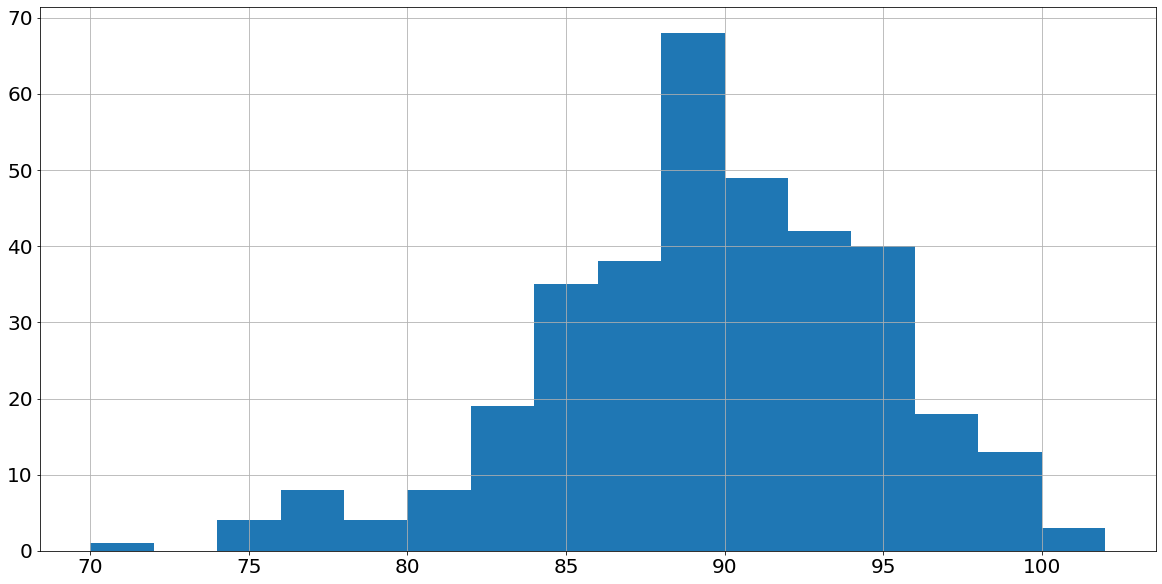

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
df.loc[df['week_of_year'] == 31, 'TMAX'].hist(bins=16, figsize=(20,10))

I haven't used Seaborn much but was looking for a way to have a smoothed line and Seaborn has an easy way to add a kernel density estimate line on top of the histogram.  So, let's give it a try.

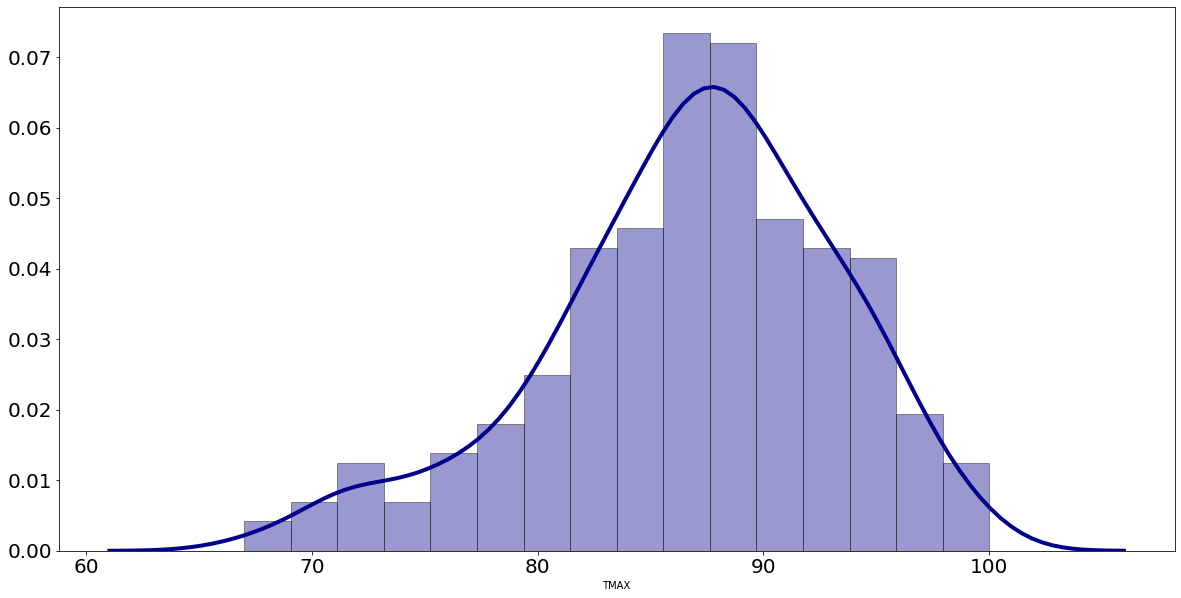

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.distplot(df.loc[df['week_of_year'] == 35, 'TMAX'], hist=True, kde=True, 
             bins=int(16), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'bw':'scott'})

I'm clearly going to have to spend more time playing with Seaborn.  It seems nice and powerful.

To make it more useful, I'd like to just give a date and get back the statistics and histograms.  So, let's create something that'll to that.  And, if we can make it a prompted field, even better.

In [23]:
date_of_interest_text = input("What date are you interested in (mm/dd/yy)?: ")
date_of_interest = datetime.datetime.strptime(date_of_interest_text, '%m/%d/%Y')
year_of_interest = date_of_interest.isocalendar()[0]
week_of_interest = date_of_interest.isocalendar()[1]

What date are you interested in (mm/dd/yy)?: 9/18/2020


In [24]:
start_of_week_of_interest = datetime.date.fromisocalendar(year_of_interest, week_of_interest, 1).strftime('%m/%d/%Y')

In [25]:
start_of_week_of_interest

'09/14/2020'

In [26]:
df_quantiles[df_quantiles['week_of_year'] == week_of_interest]

,week_of_year,TMIN_min,TMIN_05,TMIN_25,TMIN_50,TMIN_75,TMIN_95,TMIN_max,TMAX_min,TMAX_05,TMAX_25,TMAX_50,TMAX_75,TMAX_95,TMAX_max,date_2020
37,38,37,48.0,55.0,60.0,65.0,70.0,74,57,68.0,75.0,81.0,85.0,92.55,98,2020-09-14


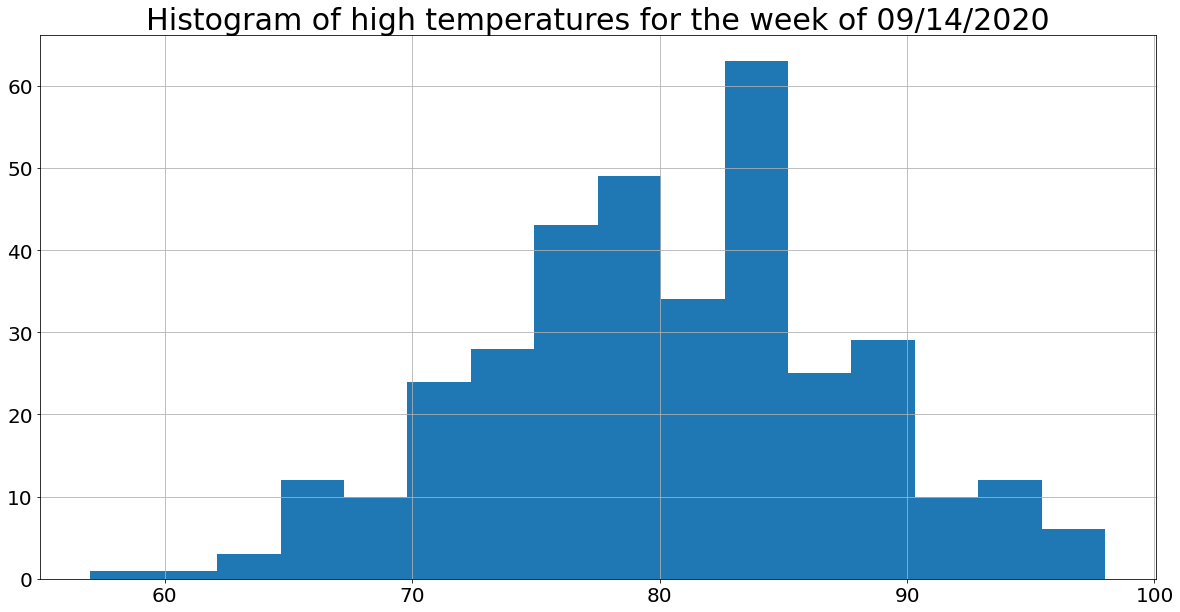

In [27]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
title_string = "Histogram of high temperatures for the week of " + start_of_week_of_interest
plt.title(title_string, fontsize=30)
df.loc[df['week_of_year'] == week_of_interest, 'TMAX'].hist(bins=16, figsize=(20,10))

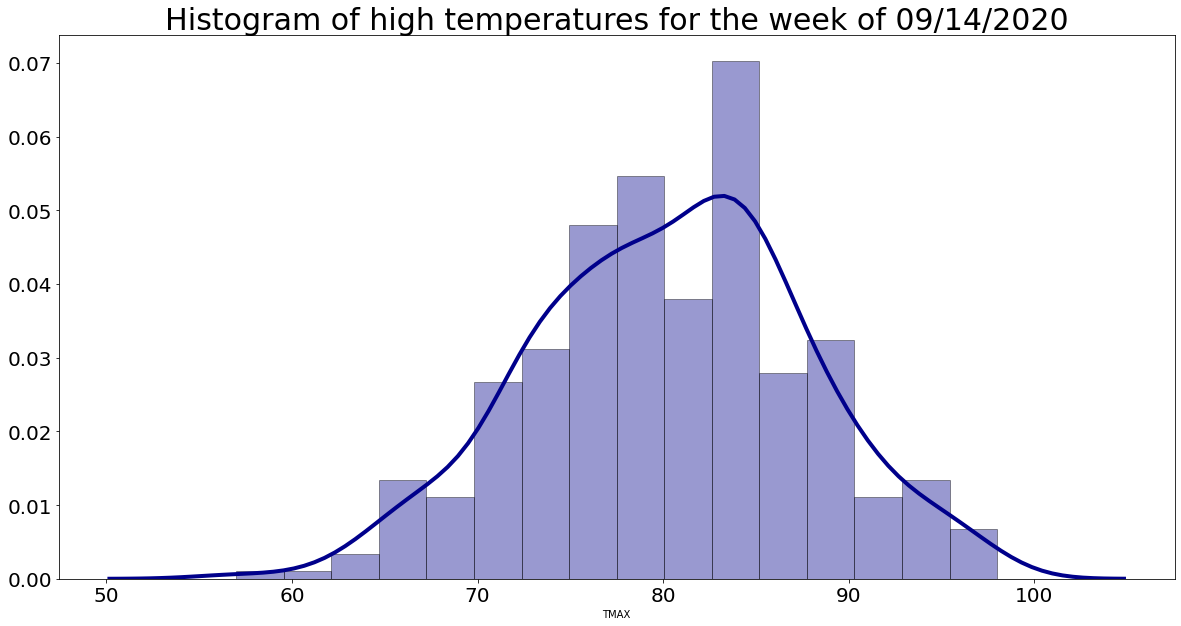

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
title_string = "Histogram of high temperatures for the week of " + start_of_week_of_interest
plt.title(title_string, fontsize=30)
sns.distplot(df.loc[df['week_of_year'] == week_of_interest, 'TMAX'], hist=True, kde=True, 
             bins=int(16), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'bw':'scott'})

What's next?  Depending on our needs, we could define some functions and keep things like setting the input file and user input in a notebook or we could go completely out of notebooks and into a script or a service.  In a service, we'd allow the user to select if they wanted daily high temperatures, daily low temperatures, or both.